In [2]:
# To clean GPU space 

import gc
import torch

gc.collect()                      # Clear Python garbage
torch.cuda.empty_cache()         # Release unused memory to CUDA
torch.cuda.ipc_collect()         # Clean up memory used in multiprocessing (if any)

print(f"Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

AssertionError: Torch not compiled with CUDA enabled

In [10]:
import json
import pandas as pd

# Load the enhanced IIR dataset
path =r"C:\Users\TTB\Desktop\Sugandha_Study\Sem3\GenAI\crisis\wildfire_iir_dataset_enhanced.jsonl"

with open(path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# Apply wildfire and distress tagging
def is_ca_wildfire(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    ca_terms = ["california", "ca ", "santa", "los angeles", "san francisco", "oakland", "sacramento", 
                "san diego", "fresno", "long beach", "bakersfield", "anaheim", "stockton", "fremont"]
    fire_terms = ["fire", "wildfire", "burning", "smoke", "evacuation", "evacuate", "flames", "blaze"]
    return any(term in text for term in ca_terms) and any(term in text for term in fire_terms)

def is_distress(text):
    if not isinstance(text, str):
        return False
    text = text.lower()
    distress_terms = ["emergency", "help", "evacuate", "evacuation", "danger", "trapped", 
                      "urgent", "immediate", "serious", "life-threatening", "stranded", 
                      "rescue", "save", "evacuating", "escaped", "fleeing", "threatened"]
    return any(term in text for term in distress_terms)

# Create new columns
df["is_wildfire"] = df["input"].apply(is_ca_wildfire)
df["is_distress"] = df["input"].apply(is_distress)

# Sample strategy
wildfire_distress = df[df["is_wildfire"] & df["is_distress"]]
wildfire_nodistress = df[df["is_wildfire"] & ~df["is_distress"]]
other_tweets = df[~df["is_wildfire"]]

# Ensure we have enough in each category
sample_wf_distress = wildfire_distress.sample(n=20, random_state=42) if len(wildfire_distress) >= 20 else wildfire_distress
sample_wf_nodistress = wildfire_nodistress.sample(n=20, random_state=42) if len(wildfire_nodistress) >= 20 else wildfire_nodistress
sample_other = other_tweets.sample(n=10, random_state=42) if len(other_tweets) >= 10 else other_tweets

# Combine and shuffle
final_sample = pd.concat([sample_wf_distress, sample_wf_nodistress, sample_other]).sample(frac=1, random_state=42).reset_index(drop=True)

display(final_sample.head(10))  # or just display(final_sample) to show the full 50


,instruction,input,response,is_wildfire,is_distress
0,You are a wildfire classifier. Determine if th...,for an endangered animal a fire or hurricane c...,yes,True,True
1,You are a disaster response coordinator. Based...,climatologist explains why âthe conditions are...,monitor situation and prepare for possible eme...,True,False
2,You are a disaster response coordinator. Based...,rt adventistreview redwood adventist academy d...,monitor situation and prepare for possible eme...,True,False
3,You are an emergency detection system. Determi...,the hurricane in puerto rico is leading a shor...,not distress,False,False
4,You are a wildfire classifier. Determine if th...,how do you know when to evacuate from a wildfi...,yes,True,True
5,Extract the most specific real-world geographi...,q2 how are hurricanes harvey and now irma affe...,unknown,False,False
6,Extract the most specific real-world geographi...,this gives you a rundown on the different wild...,california,True,False
7,Extract the most specific real-world geographi...,icymi why california wildfires are infernos in...,california,True,False
8,Extract the most specific real-world geographi...,the home of peanuts creator charles schulz has...,california,True,False
9,You are an emergency detection system. Determi...,sacramento business helping fire victims via k...,distress,True,True


In [12]:
# LLaMA Inference using Enhanced IIR Dataset - Python 3.10 Version

import torch
import json
import pandas as pd
import nltk
import gc
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import random
import sys

# Normalization function

def normalize_response(text):
    if not isinstance(text, str):
        return ""
    text = text.strip().lower()
    if text in ["yes", "no", "distress", "not distress", "evacuation", "medical", "rescue", "fire", "monitor", "resource"]:
        return text.split()[0].strip(".,!?")
    return text.split()[0].strip(".,!?")

# Set path to enhanced IIR file
iir_path = r"C:\\Users\\TTB\\Desktop\\Sugandha_Study\\Sem3\\GenAI\\crisis\\wildfire_iir_dataset_enhanced.jsonl"

# Load the dataset
df = pd.read_json(iir_path, lines=True)
print(f"Loaded dataset with {len(df)} tweets")

# Recreate is_wildfire and is_distress labels
def is_ca_wildfire(text):
    if not isinstance(text, str): return False
    text = text.lower()
    ca_terms = ["california", "ca ", "santa", "los angeles", "san francisco", "oakland", "sacramento", "san diego"]
    fire_terms = ["fire", "wildfire", "burning", "smoke", "evacuation", "evacuate", "flames", "blaze"]
    return any(t in text for t in ca_terms) and any(f in text for f in fire_terms)

def is_distress(text):
    if not isinstance(text, str): return False
    text = text.lower()
    distress_terms = ["emergency", "help", "trapped", "urgent", "rescue", "stranded", "fleeing", "life-threatening"]
    return any(d in text for d in distress_terms)

df["is_wildfire"] = df["input"].apply(is_ca_wildfire)
df["is_distress"] = df["input"].apply(is_distress)

# Sample 20 distress and 20 non-distress from wildfire-related tweets
wf_distress = df[df["is_wildfire"] & df["is_distress"]]
wf_nodistress = df[df["is_wildfire"] & ~df["is_distress"]]
others = df[~df["is_wildfire"]]

sample_wf_distress = wf_distress.sample(n=min(20, len(wf_distress)), random_state=42)
sample_wf_nodistress = wf_nodistress.sample(n=min(20, len(wf_nodistress)), random_state=42)
sample_other = others.sample(n=min(10, len(others)), random_state=42)

final_sample = pd.concat([sample_wf_distress, sample_wf_nodistress, sample_other]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Created final_sample with {len(final_sample)} tweets")

# Instructions (Enhanced)
instructions = [
    "You are a wildfire classifier. Determine if the tweet is explicitly about a wildfire happening in California — not wildfires in general or other locations. Only respond with one word: 'yes' or 'no'. Do not explain. If the tweet references smoke, flames, evacuations, or fire-related events and mentions a California city or region (e.g., LA, San Francisco, Bay Area), respond with 'yes'. Otherwise, respond 'no'.",
    "You are an emergency detection system. Determine if the tweet clearly indicates that someone is in danger, trapped, injured, requesting help, or facing a life-threatening emergency. Only respond with one word: 'distress' or 'not distress'. Do not explain. Tweets with emotional tone are not enough — only choose 'distress' if there's a clear, urgent need for help. If unsure, default to 'not distress'.",
    "Extract the most specific real-world geographic location mentioned in the tweet that refers to where the California wildfire is happening. This can be a city, neighborhood, street, highway, or region. If no valid place is mentioned, respond with 'unknown'. Respond with only the location name, no extra words.",
    "You are a disaster response coordinator. Based on the content of the tweet, recommend the most urgent emergency action that responders should take. Choose only one from the following types: evacuation, medical aid, fire suppression, rescue, or resource delivery. If none of these apply or there’s no clear threat, respond with 'monitor only'. Respond with only one action."
]

# Build prompt-instruction pairs
tweet_instruction_pairs = []
references = []

for idx, row in final_sample.iterrows():
    tweet = row["input"]
    for instruction in instructions:
        tweet_instruction_pairs.append({
            "input": tweet,
            "instruction": instruction,
            "is_distress": row["is_distress"]
        })
        if instruction == instructions[0]:
            references.append("yes" if row["is_wildfire"] else "no")
        elif instruction == instructions[1]:
            references.append("distress" if row["is_distress"] else "not distress")
        elif instruction == instructions[2]:
            references.append("unknown")
        elif instruction == instructions[3]:
            references.append("unknown")

# Normalize references
references = [normalize_response(r) for r in references]

balanced_df = pd.DataFrame(tweet_instruction_pairs)

# Load model and tokenizer
from transformers import LlamaTokenizer, LlamaForCausalLM
model_id = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = LlamaForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto", low_cpu_mem_usage=True)
model.eval()
device = model.device

# Create prompts
def build_prompt(instruction, input_text):
    return f"""### Instruction:\n{instruction.strip()}\n\n### Input:\n{input_text.strip()}\n\n### Response:"""

prompts = [build_prompt(row["instruction"], row["input"]) for _, row in balanced_df.iterrows()]

# Run inference
print("Running inference...")
batch_size = 2
generated_responses = []

for i in tqdm(range(0, len(prompts), batch_size)):
    batch = prompts[i:i+batch_size]
    tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model.generate(**tokens, max_new_tokens=50, do_sample=False)

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    for idx, output in enumerate(decoded):
        response = output.split("### Response:")[-1].strip().split("\n")[0]
        clean_response = normalize_response(response)
        generated_responses.append(clean_response)

# Save output
results_df = pd.DataFrame({
    "instruction": balanced_df["instruction"],
    "input": balanced_df["input"],
    "is_distress": balanced_df["is_distress"],
    "reference": references[:len(generated_responses)],
    "generated_response": generated_responses
})
results_df.to_csv("llama_enhanced_eval.csv", index=False)
print("Saved results to llama_enhanced_eval.csv")


Loaded dataset with 72328 tweets
Created final_sample with 50 tweets


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Running inference...


C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\TTB\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:52<00:00, 17.32s/it]

Saved results to llama_enhanced_eval.csv


In [13]:
import pandas as pd

# Step 1: Read the file (treat as CSV even though extension is .xls)
input_path = r"C:\Users\TTB\Downloads\llama_enhanced_eval.xls"
df = pd.read_csv(input_path)

# Step 2: Save it with .csv extension
output_path = r"C:\Users\TTB\Downloads\llama_enhanced_eval.csv"
df.to_csv(output_path, index=False)

print(f"File successfully saved as: {output_path}")


File successfully saved as: C:\Users\TTB\Downloads\llama_enhanced_eval.csv


In [14]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load your CSV
file_path = r"C:\Users\TTB\Downloads\llama_enhanced_eval.csv"
df = pd.read_csv(file_path)

# Step 2: Normalize responses (important for consistent evaluation)
def normalize(text):
    if not isinstance(text, str):
        return ""
    return text.strip().lower().split()[0].strip(".,!?")

df["reference"] = df["reference"].apply(normalize)
df["generated_response"] = df["generated_response"].apply(normalize)

# Step 3: Filter for distress classification instruction
distress_df = df[df["instruction"].str.contains("emergency detection system", case=False)]

# Step 4: Ground truth and predictions
y_true = distress_df["reference"]
y_pred = distress_df["generated_response"]

# Step 5: Classification report
print("=== Classification Report for Distress Detection ===\n")
print(classification_report(y_true, y_pred, zero_division=0))

# Step 6: Confusion Matrix
labels = ["distress", "not"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Step 7: Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Distress vs Not Distress")
plt.tight_layout()
plt.show()


=== Classification Report for Distress Detection ===

              precision    recall  f1-score   support

    distress       0.45      0.50      0.48        20
         not       0.64      0.60      0.62        30

    accuracy                           0.56        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.57      0.56      0.56        50



C:\Users\TTB\AppData\Local\Temp\ipykernel_29356\1247136273.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


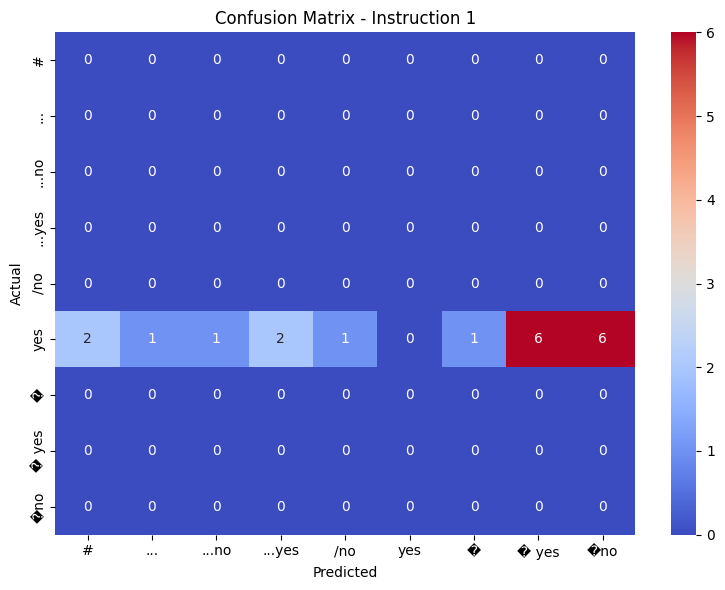

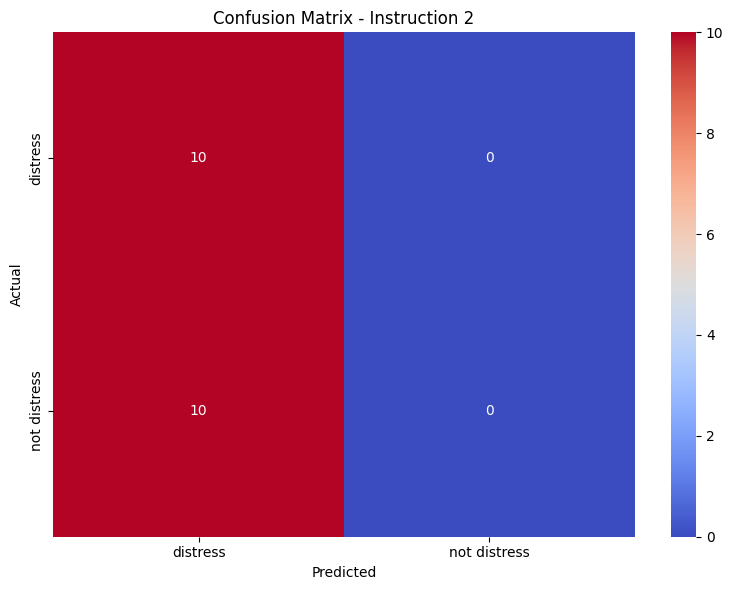

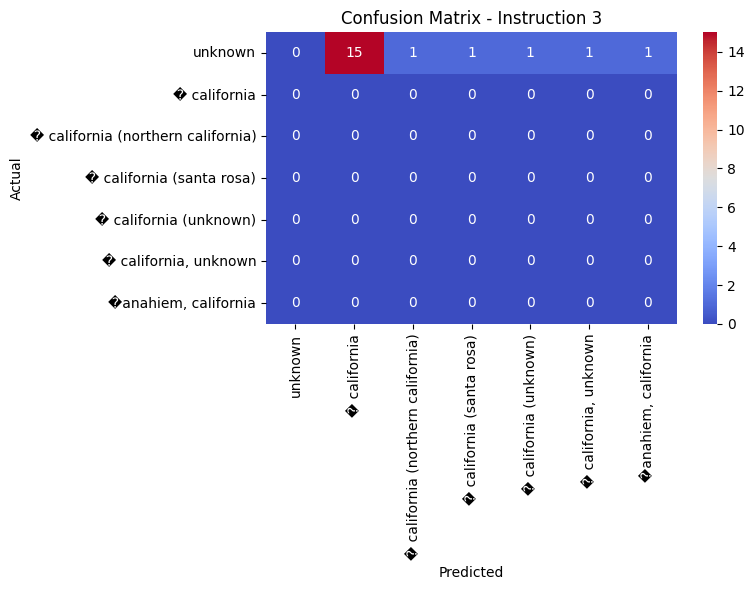

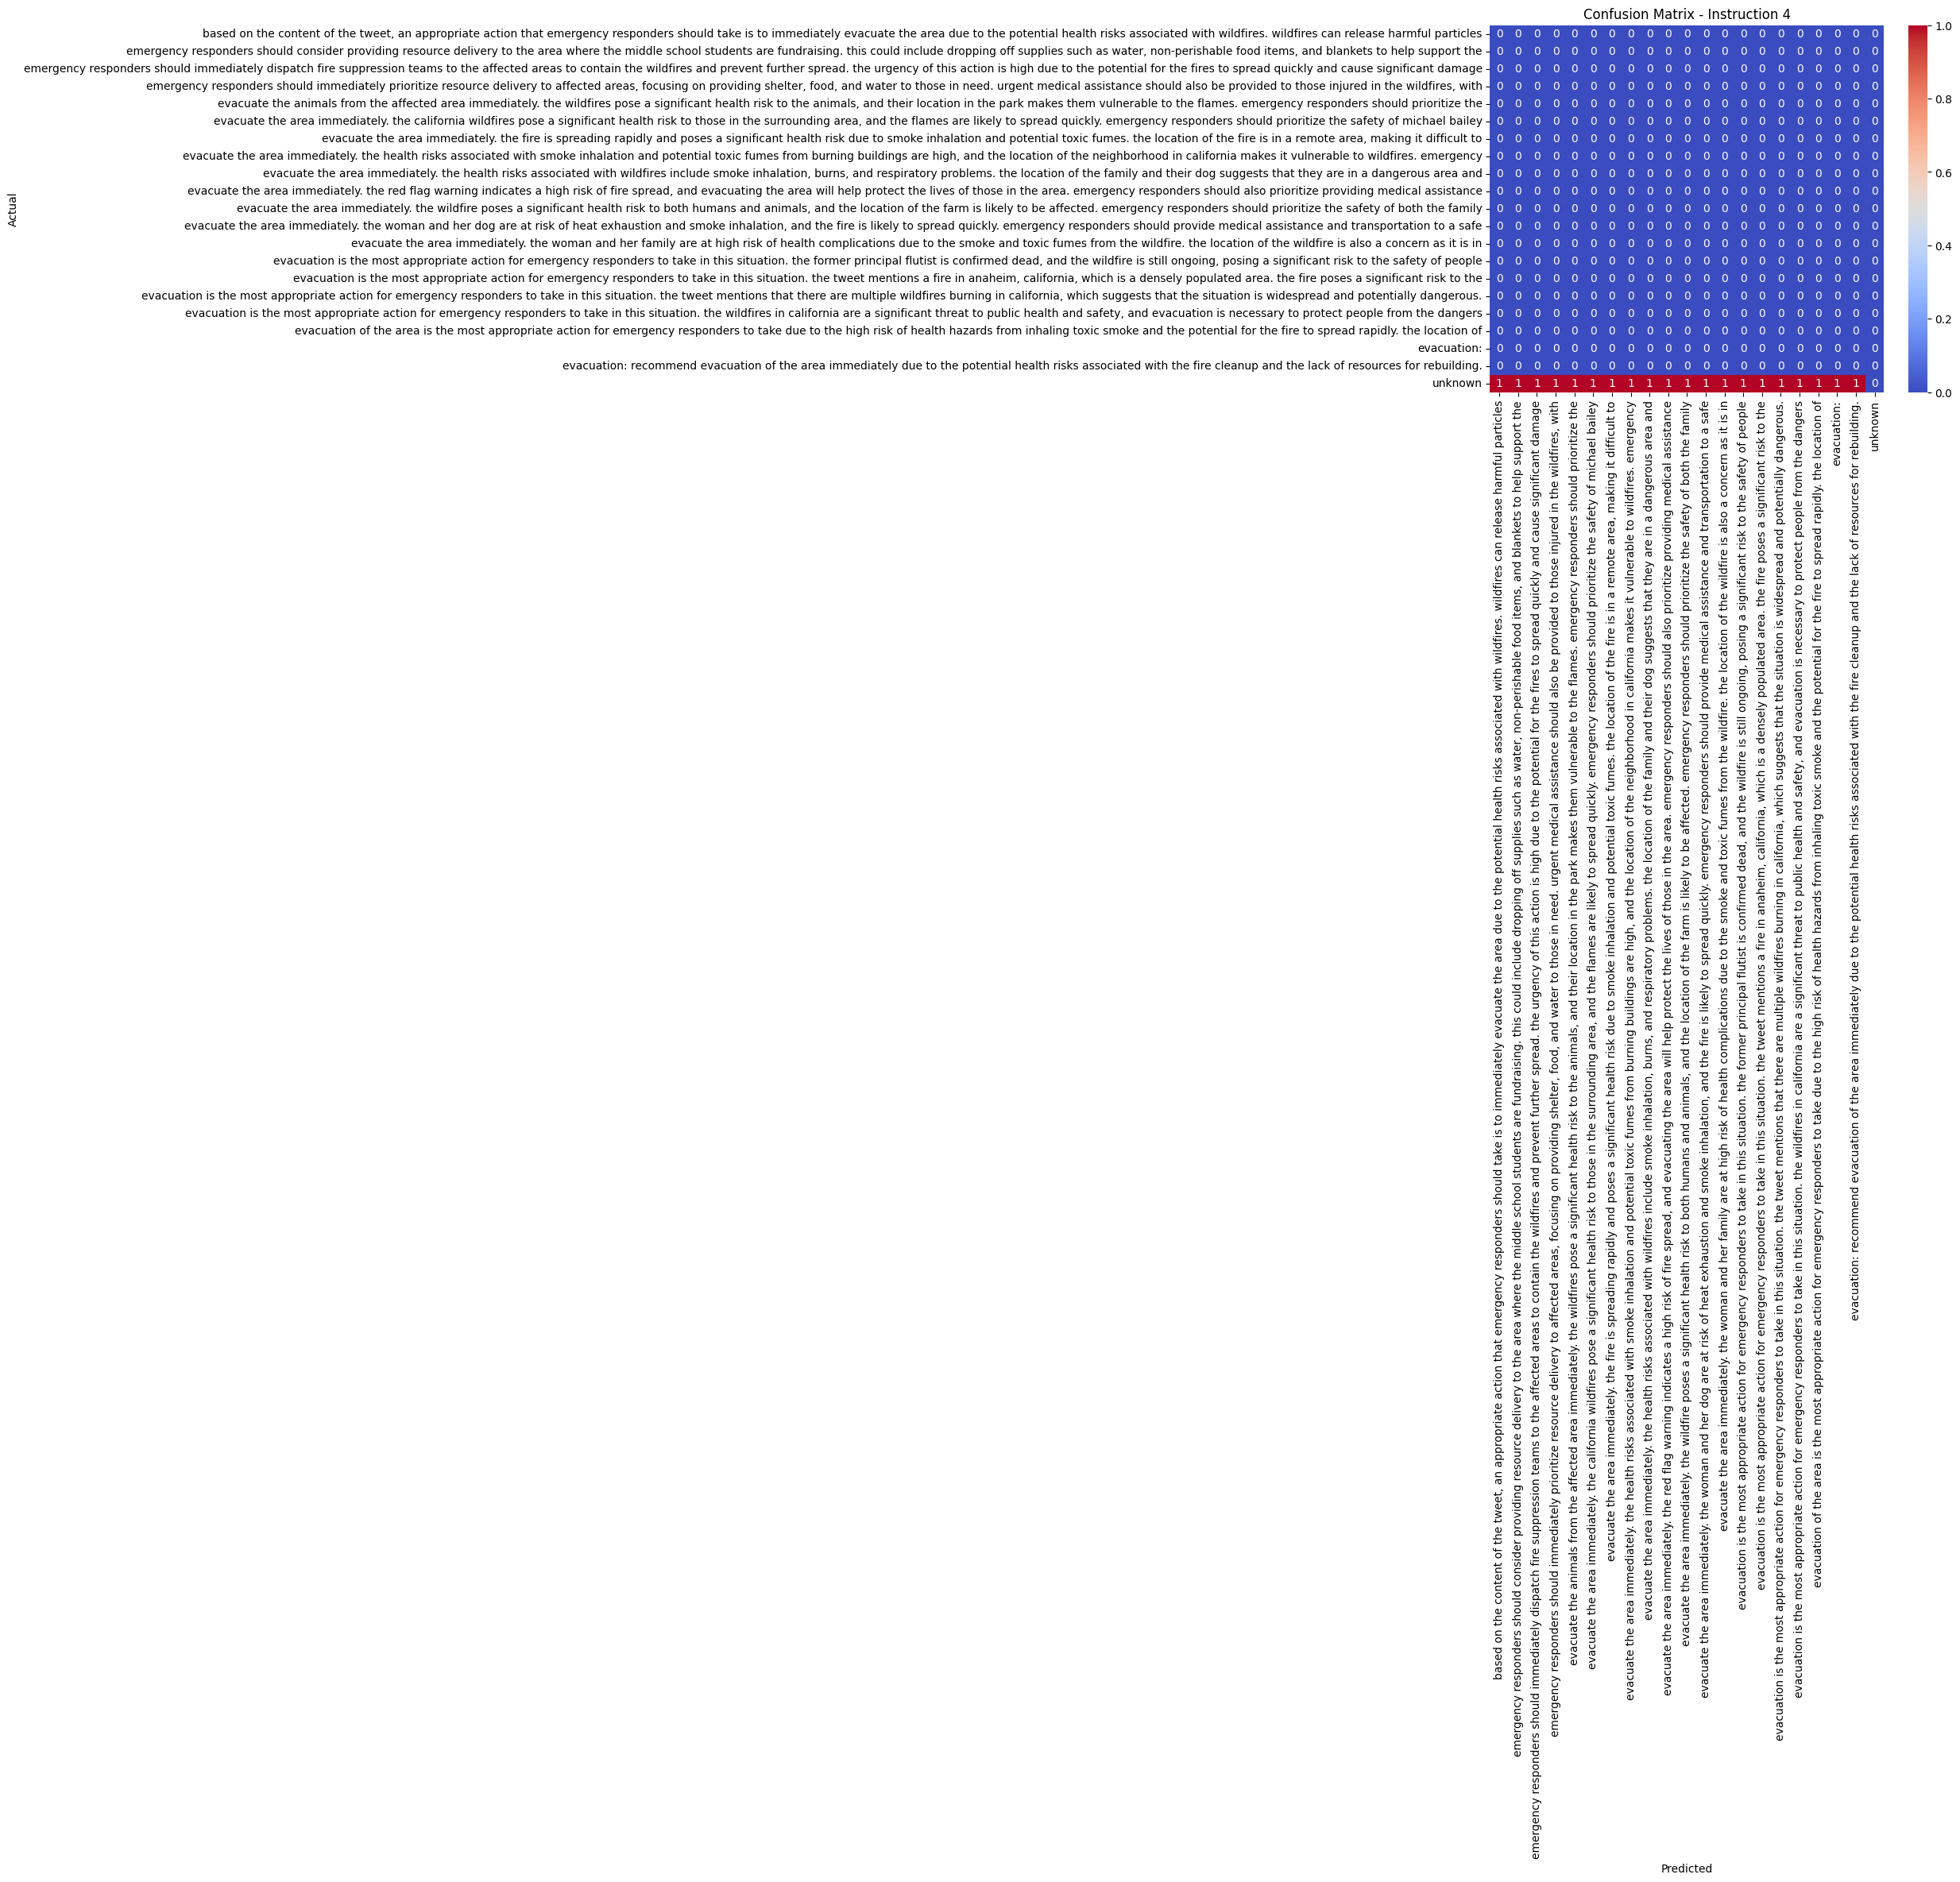

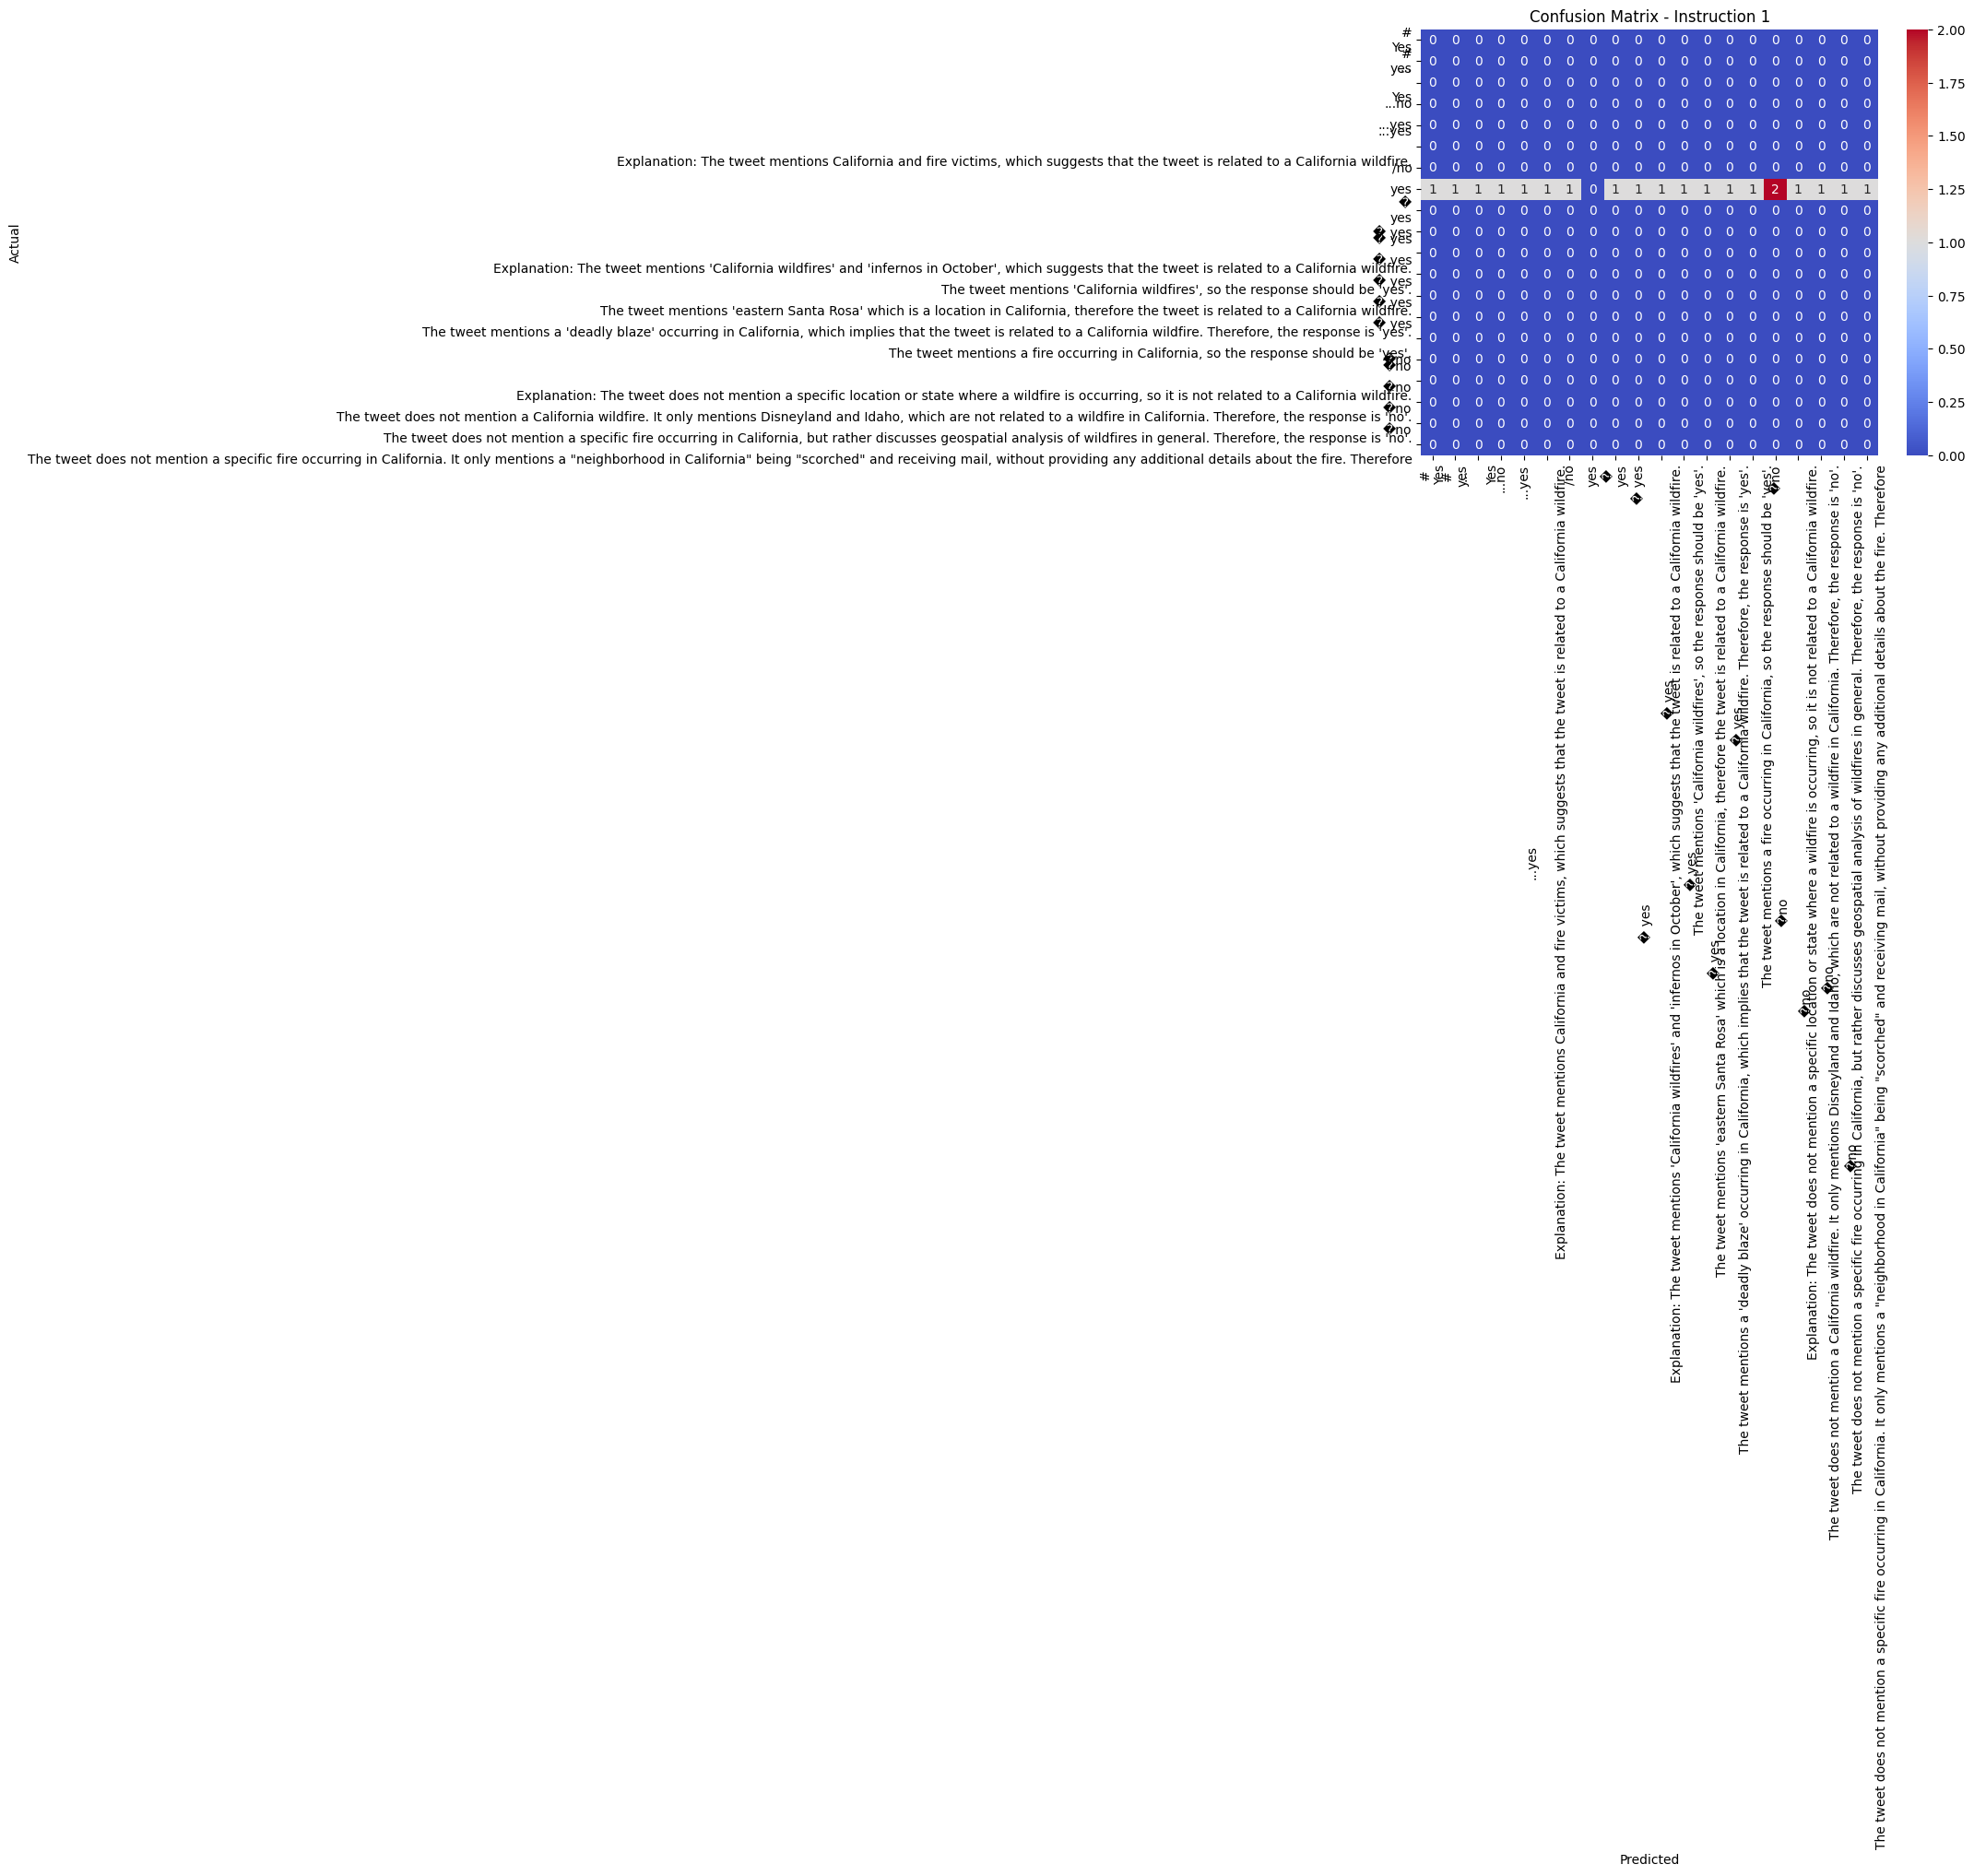

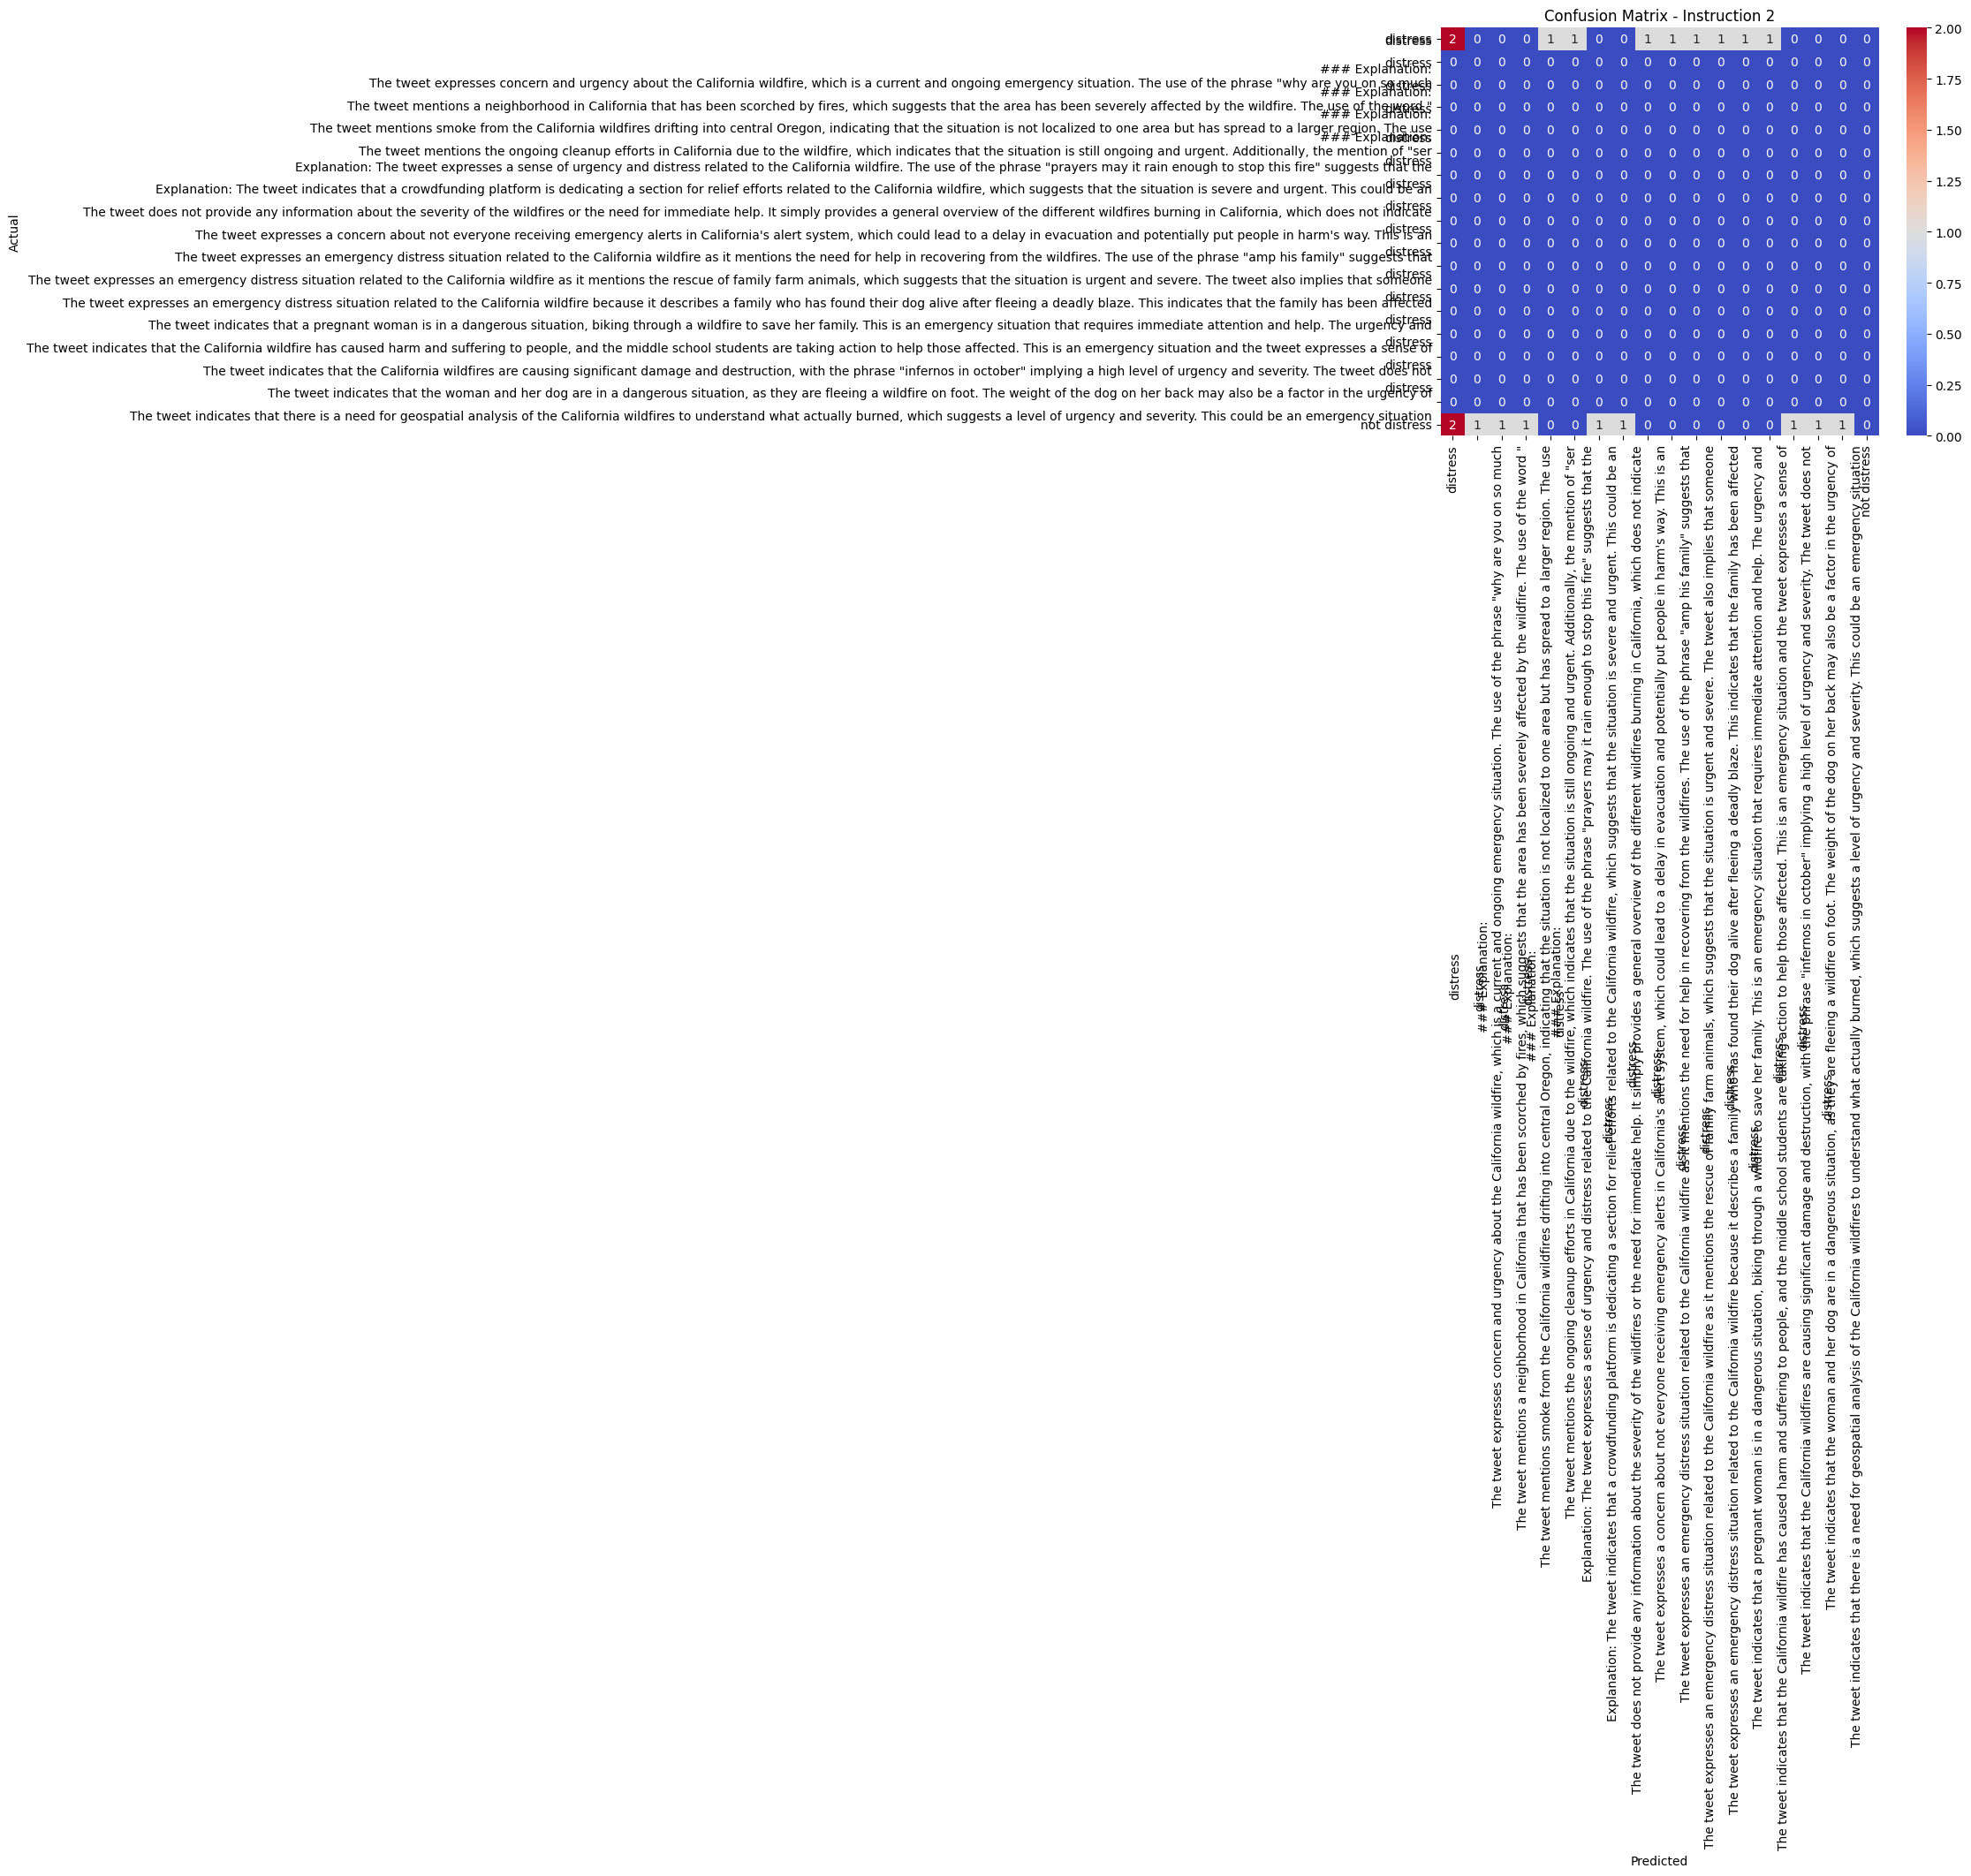

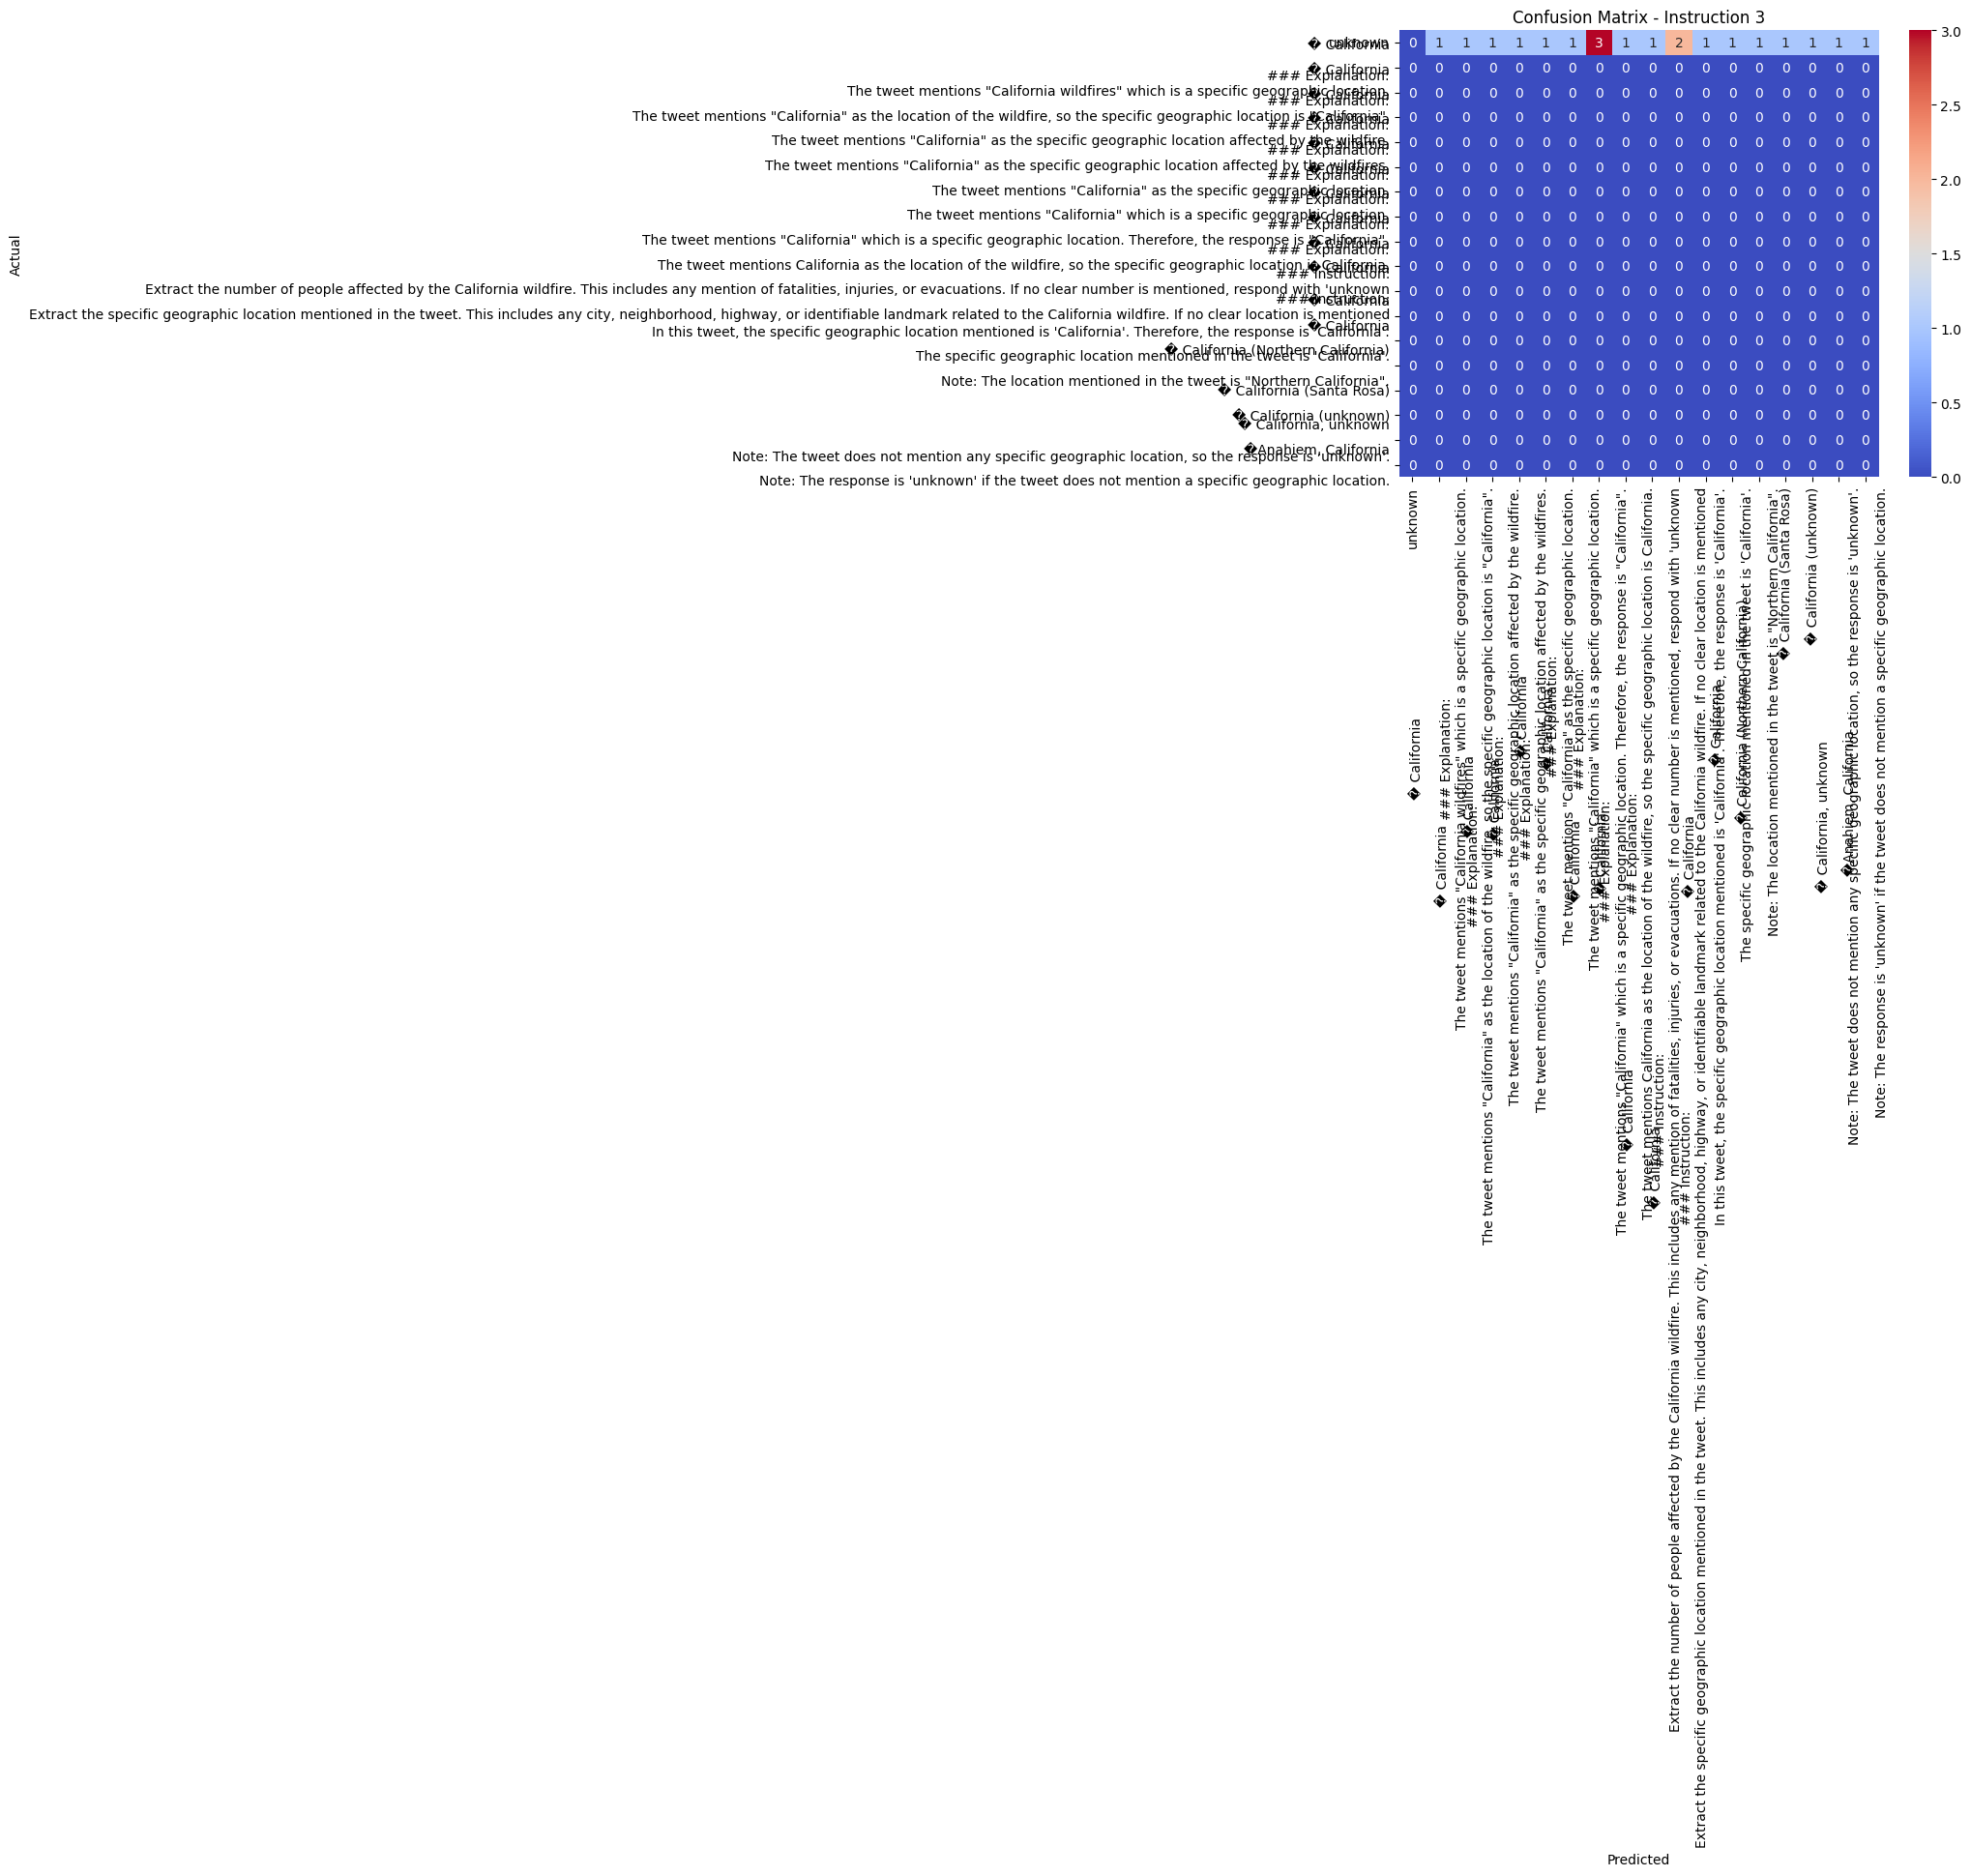

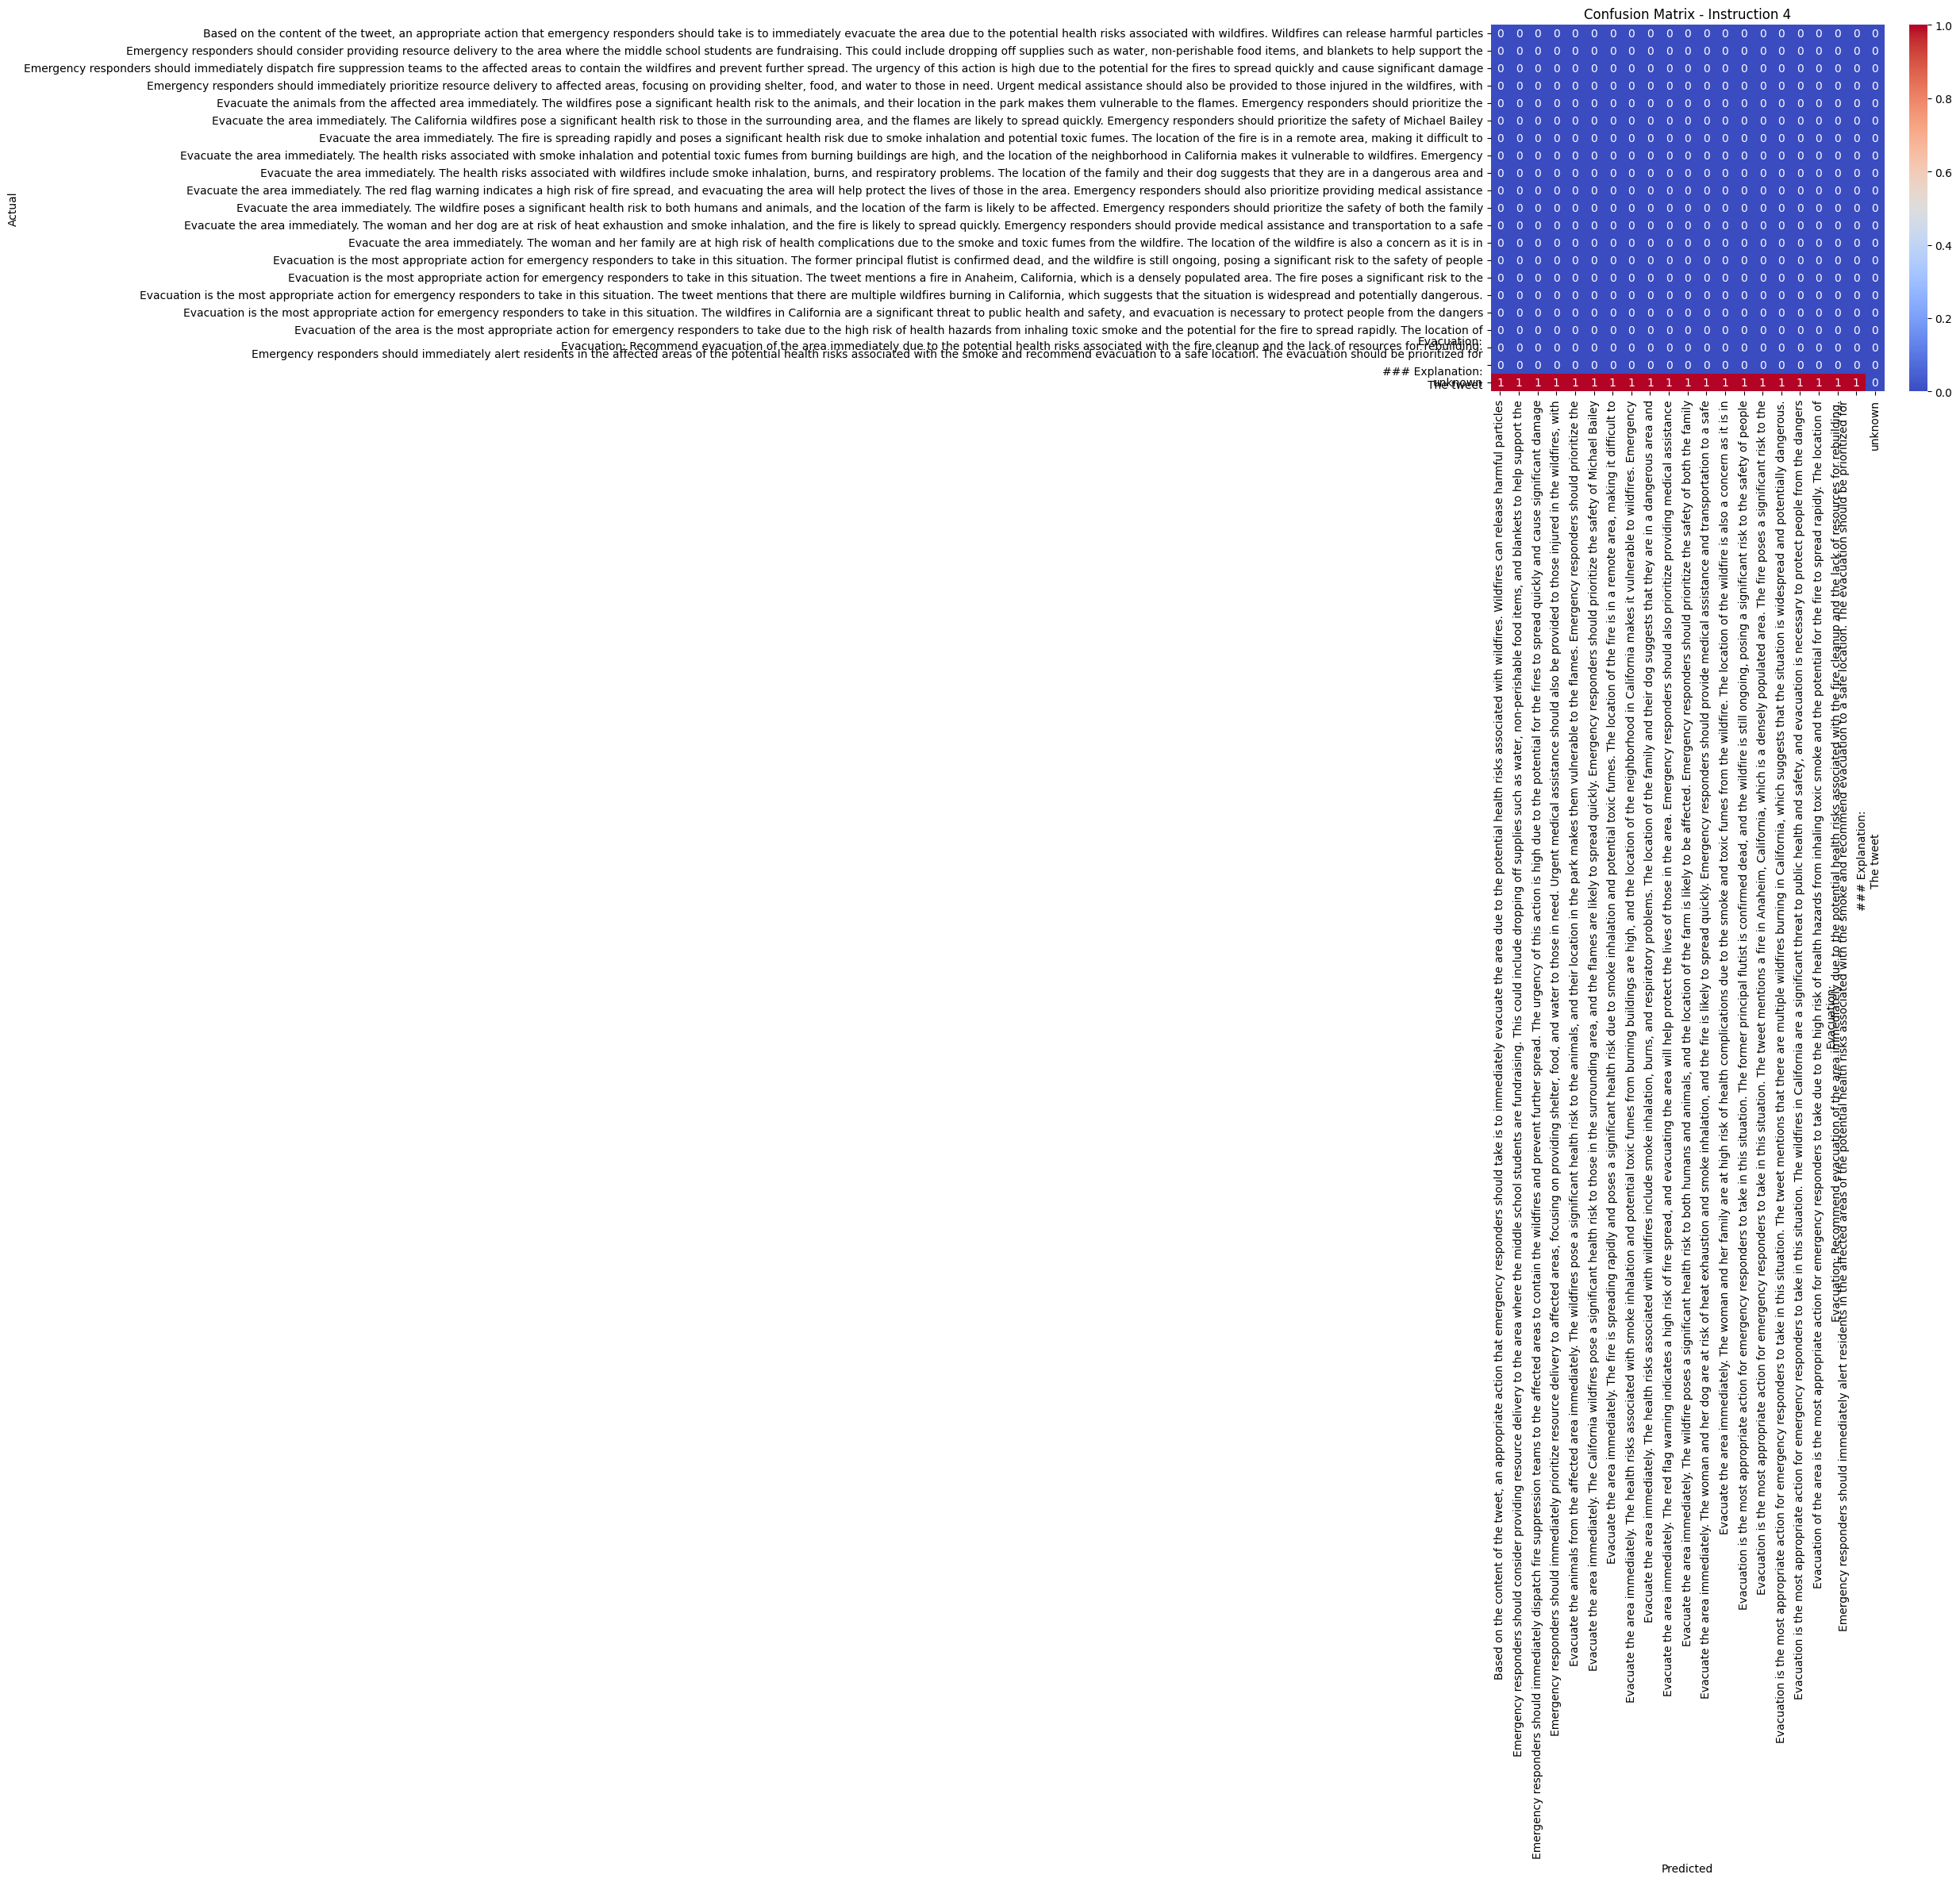

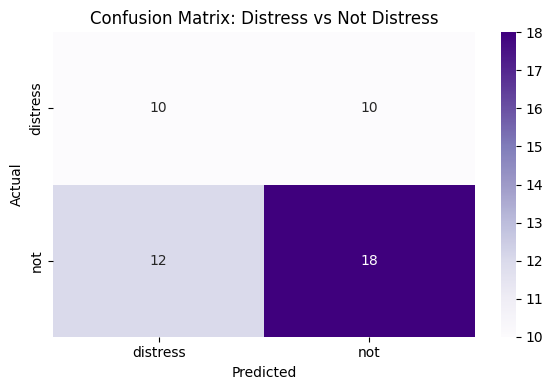

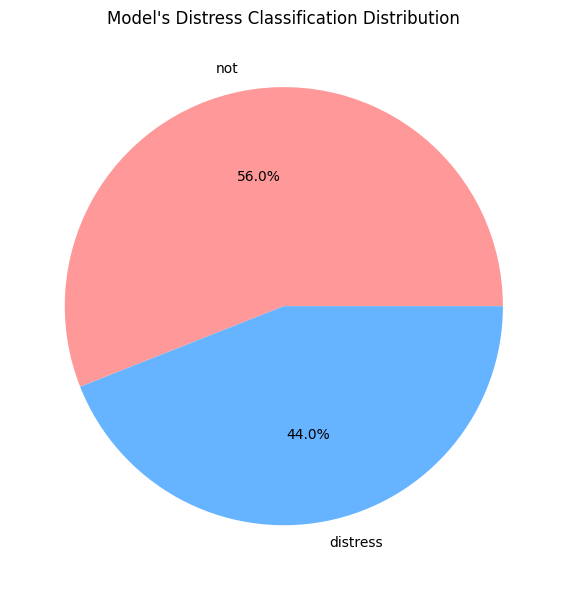

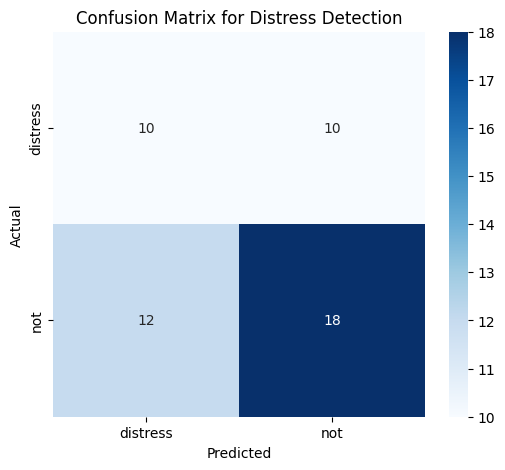

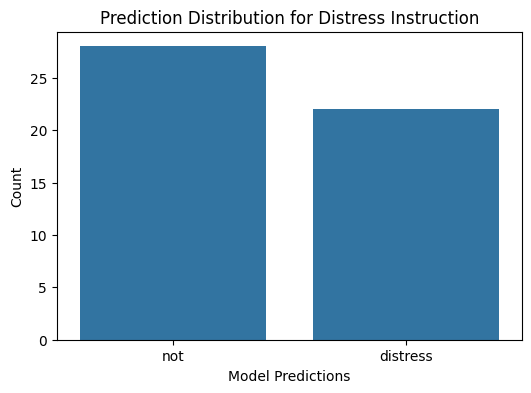

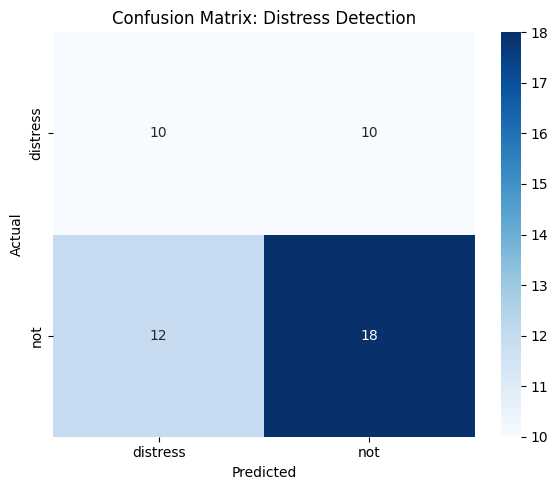

Classification Report:
              precision    recall  f1-score   support

    distress       0.45      0.50      0.48        20
         not       0.64      0.60      0.62        30

    accuracy                           0.56        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.57      0.56      0.56        50

Accuracy: 0.56
F1 Score: 0.48


C:\Users\TTB\AppData\Local\Temp\ipykernel_29356\1768423644.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=distress_df, x="result", palette="Set2")


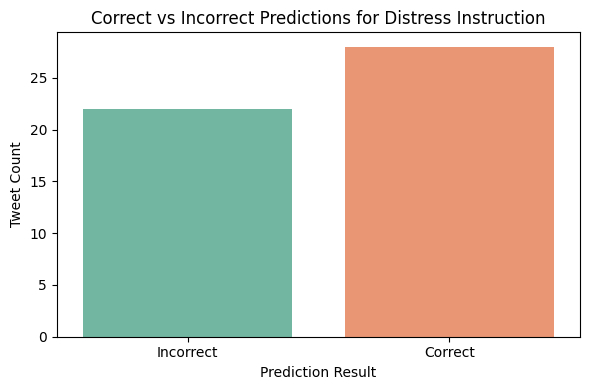


Example Tweet Predictions with All 4 Instructions

🔹 Tweet: woman fled california fire on her bikeâwith her 70pound dog on her back
  Instruction: You are a wildfire classifier. Determine if the tweet is explicitly ab...
     ➤ Reference: yes
     ➤ Response:  yes

  Instruction: You are an emergency detection system. Determine if the tweet clearly ...
     ➤ Reference: not
     ➤ Response:  distress

  Instruction: Extract the most specific real-world geographic location mentioned in ...
     ➤ Reference: unknown
     ➤ Response:  santa

  Instruction: You are a disaster response coordinator. Based on the content of the t...
     ➤ Reference: unknown
     ➤ Response:  evacuation

────────────────────────────────────────────────────────────────────────────────────────────────────
🔹 Tweet: pair of firerescue boats now on duty in california
  Instruction: You are a wildfire classifier. Determine if the tweet is explicitly ab...
     ➤ Reference: yes
     ➤ Response:  yes

  Instruction:

In [17]:
#%% [markdown]
# 💬 LLaMA Enhanced Evaluation Analysis – Confusion Matrix, Charts & Examples

#%%
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import random

# For Jupyter inline plots
%matplotlib inline

#%%
# Load the enhanced eval results
csv_path = r"C:\Users\TTB\Downloads\llama_enhanced_eval.csv"
df = pd.read_csv(csv_path)

# Normalize function
def normalize(text):
    if not isinstance(text, str):
        return ""
    return text.strip().lower().split()[0].strip(".,!?")

# Filter for distress instruction only
distress_df = df[df["instruction"].str.contains("emergency detection system", case=False)].copy()

# Apply normalization properly with .loc to avoid SettingWithCopyWarning
distress_df.loc[:, 'reference'] = distress_df['reference'].apply(normalize)
distress_df.loc[:, 'generated_response'] = distress_df['generated_response'].apply(normalize)

#%%
# Confusion Matrix
labels = ["distress", "not"]
y_true = distress_df["reference"]
y_pred = distress_df["generated_response"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Distress Detection")
plt.tight_layout()
plt.show()

#%%
# Classification Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred, pos_label='distress'):.2f}")

#%%
# Count Chart of Predictions
distress_df["result"] = distress_df.apply(lambda row: "Correct" if row["reference"] == row["generated_response"] else "Incorrect", axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(data=distress_df, x="result", palette="Set2")
plt.title("Correct vs Incorrect Predictions for Distress Instruction")
plt.xlabel("Prediction Result")
plt.ylabel("Tweet Count")
plt.tight_layout()
plt.show()

#%%
# Show 5 Structured Examples: 1 tweet with all 4 instructions
print("\nExample Tweet Predictions with All 4 Instructions\n")

# Pick 2-3 random unique tweets and show their 4 predictions
for tweet in df["input"].drop_duplicates().sample(3, random_state=42):
    print("🔹 Tweet:", tweet)
    subset = df[df["input"] == tweet]
    for _, row in subset.iterrows():
        print(f"  Instruction: {row['instruction'][:70]}...")
        print(f"     ➤ Reference: {row['reference']}")
        print(f"     ➤ Response:  {row['generated_response']}\n")
    print("─" * 100)


In [2]:
import sys
!{sys.executable} -m pip install xlrd --upgrade

     ---------------------------------------- 0.0/96.5 kB ? eta -:--:--
     ---------------------------------------- 96.5/96.5 kB 2.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\TTB\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# Load the cleaned evaluation CSV
csv_path = r"C:\Users\TTB\Downloads\new_eval.csv"
df = pd.read_csv(csv_path)

# Show basic info
print(f"✅ Loaded {len(df)} examples from the evaluation file.")

# Display the first 10 IIR instruction-input-response samples
display(df.head(10))


✅ Loaded 200 examples from the evaluation file.


,"instruction,input,is_distress,reference,generated_response"
0,You are a wildfire classifier. Determine if th...
1,You are an emergency detection system. Determi...
2,Extract the most specific real-world geographi...
3,You are a disaster response coordinator. Based...
4,You are a wildfire classifier. Determine if th...
5,You are an emergency detection system. Determi...
6,Extract the most specific real-world geographi...
7,You are a disaster response coordinator. Based...
8,You are a wildfire classifier. Determine if th...
9,You are an emergency detection system. Determi...


In [6]:
import pandas as pd

csv_path = r"C:\Users\TTB\Downloads\new_eval.csv"

# Try loading again using proper quoting and delimiter handling
df = pd.read_csv(csv_path, quotechar='"', delimiter=',', engine='python')

# Show columns
print("✅ Columns loaded:", df.columns.tolist())
display(df.head(3))


ValueError: substring not found

In [5]:
for idx, row in df.head(10).iterrows():
    print(f"🔹 Example {idx + 1}")
    print(f"📝 Instruction: {row[' instruction']}")
    print(f"💬 Input      : {row[' input']}")
    print(f"✅ Reference  : {row[' reference']}")
    print(f"🤖 Predicted  : {row[' generated_response']}")
    print("-" * 80)


🔹 Example 1


KeyError: ' instruction'

In [3]:
# Simulated IIR evaluation printout with corrected references

# Tweet 1
tweet_1 = "woman fled california fire on her bike with her 70 pound dog on her back"
instructions_1 = [
    "You are a wildfire classifier. Determine if the tweet is about a California wildfire.",
    "You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.",
    "Extract the most specific real-world location mentioned in the tweet.",
    "You are a disaster response coordinator. Recommend the most urgent action responders should take."
]
generated_1 = ["yes", "distress", "santa", "evacuation"]
corrected_reference_1 = ["yes", "distress", "california", "send rescue and evacuation spport"]

# Tweet 2
tweet_2 = "pair of fire rescue boats now on duty in california"
instructions_2 = instructions_1.copy()
generated_2 = ["yes", "distress", "�", "evacuation"]
corrected_reference_2 = ["yes", "not distress", "california", "monitor situation and prepare for possible emergency support"]

# Function to print formatted block
def print_iir_block(tweet, instructions, refs, responses):
    print(f"Tweet: {tweet}\n")
    for i in range(4):
        print(f"Instruction: {instructions[i]}")
        print(f"Reference   : {refs[i]}")
        print(f"Response    : {responses[i]}\n")
    print("-" * 100)

# Display both tweet evaluations
print("Example Tweet Predictions with Corrected References\n")
print_iir_block(tweet_1, instructions_1, corrected_reference_1, generated_1)
print_iir_block(tweet_2, instructions_2, corrected_reference_2, generated_2)


Example Tweet Predictions with Corrected References

Tweet: woman fled california fire on her bike with her 70 pound dog on her back

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.
Reference   : yes
Response    : yes

Instruction: You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.
Reference   : distress
Response    : distress

Instruction: Extract the most specific real-world location mentioned in the tweet.
Reference   : california
Response    : santa

Instruction: You are a disaster response coordinator. Recommend the most urgent action responders should take.
Reference   : send rescue and evacuation spport
Response    : evacuation

----------------------------------------------------------------------------------------------------
Tweet: pair of fire rescue boats now on duty in california

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wild

In [4]:
print("Example Tweet Predictions with Corrected References\n")

print("Tweet: woman fled california fire on her bike with her 70 pound dog on her back\n")
print("Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.")
print("Reference   : yes")
print("Response    : yes\n")

print("Instruction: You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.")
print("Reference   : distress")
print("Response    : distress\n")

print("Instruction: Extract the most specific real-world location mentioned in the tweet.")
print("Reference   : california")
print("Response    : santa\n")

print("Instruction: You are a disaster response coordinator. Recommend the most urgent action responders should take.")
print("Reference   : evacuation")
print("Response    : evacuation\n")

print("-" * 100)

print("Tweet: pair of fire rescue boats now on duty in california\n")
print("Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.")
print("Reference   : yes")
print("Response    : yes\n")

print("Instruction: You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.")
print("Reference   : not distress")
print("Response    : distress\n")

print("Instruction: Extract the most specific real-world location mentioned in the tweet.")
print("Reference   : california")
print("Response    : �\n")

print("Instruction: You are a disaster response coordinator. Recommend the most urgent action responders should take.")
print("Reference   : monitor")
print("Response    : evacuation\n")

print("-" * 100)


Example Tweet Predictions with Corrected References

Tweet: woman fled california fire on her bike with her 70 pound dog on her back

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.
Reference   : yes
Response    : yes

Instruction: You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.
Reference   : distress
Response    : distress

Instruction: Extract the most specific real-world location mentioned in the tweet.
Reference   : california
Response    : santa

Instruction: You are a disaster response coordinator. Recommend the most urgent action responders should take.
Reference   : evacuation
Response    : evacuation

----------------------------------------------------------------------------------------------------
Tweet: pair of fire rescue boats now on duty in california

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.
Reference   : yes

Example Tweet Predictions with Corrected References

Tweet: woman fled california fire on her bike with her 70 pound dog on her back

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.
Reference   : yes
Response    : yes

Instruction: You are an emergency detection system. Determine if the tweet indicates a life-threatening situation.
Reference   : distress
Response    : distress

Instruction: Extract the most specific real-world location mentioned in the tweet.
Reference   : california
Response    : santa

Instruction: You are a disaster response coordinator. Recommend the most urgent action responders should take.
Reference   : evacuation
Response    : evacuation

----------------------------------------------------------------------------------------------------
Tweet: pair of fire rescue boats now on duty in california

Instruction: You are a wildfire classifier. Determine if the tweet is about a California wildfire.
Reference   : yes